In [ ]:
# 필요한 라이브러리 설치
!pip install roboflow
!pip install mediapipe
!pip install shap
!pip install opencv-python

# 필요한 라이브러리 import
import roboflow
import mediapipe as mp
import shap
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import cv2

In [ ]:
# 필요한 라이브러리 import
import roboflow
import mediapipe as mp
import shap
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import cv2
import os

# Mediapipe 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# 이미지를 로드하고 포인트 검출하여 특징 추출
def extract_features_from_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    keypoints = []
    if results.pose_landmarks:
        mapping = {
            "wrist": [15, 16],
            "elbow": [13, 14],
            "shoulder": [11, 12]
        }
        for part, indices in mapping.items():
            for idx in indices:
                keypoints.extend([results.pose_landmarks.landmark[idx].x, results.pose_landmarks.landmark[idx].y])
    return keypoints

# 로보플로우에서 생성된 데이터셋 다운로드 링크
download_link = "https://app.roboflow.com/ds/2pyPAQpO2Y?key=zyxmZi1KqM"

# 데이터셋 다운로드
dataset_path = "/content/dataset"
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

# 데이터셋 다운로드
os.system(f"wget {download_link} -O /content/dataset.zip")
os.system(f"unzip /content/dataset.zip -d {dataset_path}")

# 클래스별로 데이터셋 분류
data = []
class_mapping = {
    "Pull": 0,
    "Push": 1,
    "Middle": 2
}

# class_data 정의
class_data = {
    "Pull": [],
    "Push": [],
    "Middle": []
}

for class_name, label in class_mapping.items():
    class_path = os.path.join(dataset_path, "train", class_name)
    image_files = os.listdir(class_path)
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        features = extract_features_from_image(image_path)
        data.append((features, label))
        # 클래스별로 데이터 추가
        class_data[class_name].append(features)

# 데이터셋을 X, y로 분리
X = np.array([d[0] for d in data])
y = np.array([d[1] for d in data])


In [ ]:
# RandomForestClassifier 모델 생성 및 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP 분석을 위한 준비
explainer = shap.TreeExplainer(model)

# feature_names 추출
feature_names = [
    'left_wrist_x', 'left_wrist_y', 'right_wrist_x', 'right_wrist_y',
    'left_elbow_x', 'left_elbow_y', 'right_elbow_x', 'right_elbow_y',
    'left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x', 'right_shoulder_y'
]

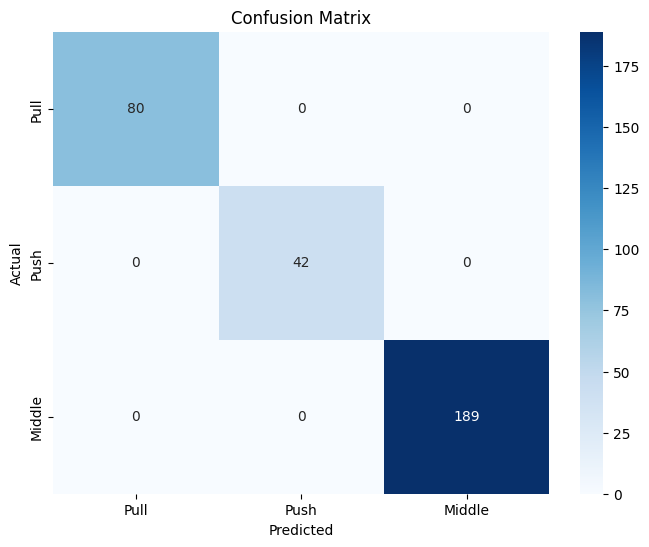

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# RandomForestClassifier 모델 생성 및 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# 예측값 계산
y_pred = model.predict(X)

# 혼동 행렬 계산
cm = confusion_matrix(y, y_pred)

# 혼동 행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


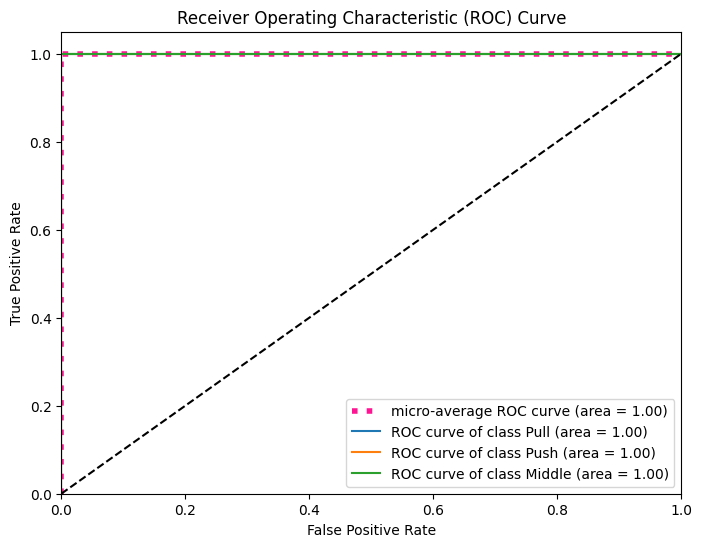

In [ ]:
# 정확도 계산
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 정밀도, 재현율, F1 점수 계산
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


# ROC 곡선 및 AUC 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

# 클래스를 이진 분류로 변환
y_binarized = label_binarize(y, classes=[0, 1, 2])

# 예측 확률 계산
y_scores = model.predict_proba(X)

# 각 클래스에 대한 ROC curve 및 AUC 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_mapping)):
    fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 마이크로 평균 ROC curve 및 AUC 계산
fpr["micro"], tpr["micro"], _ = roc_curve(y_binarized.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

for i, class_name in enumerate(class_mapping.keys()):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

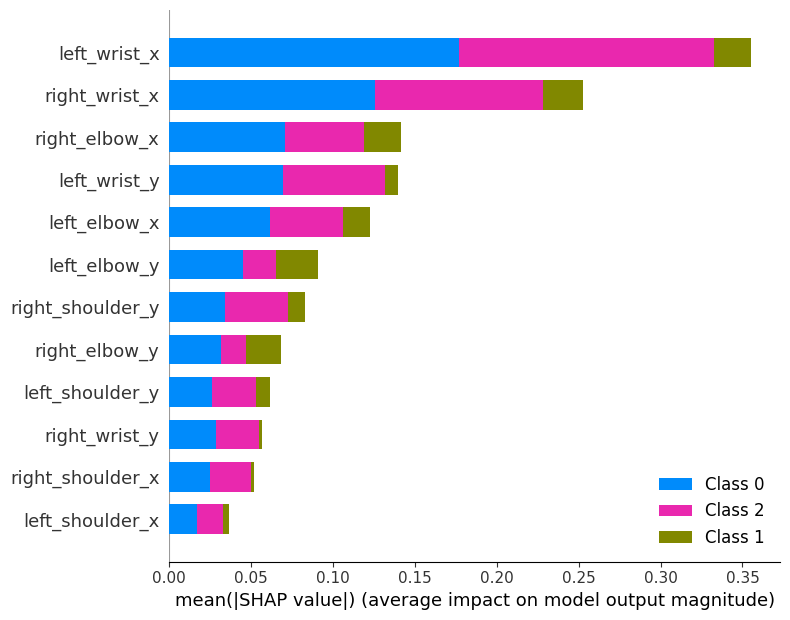

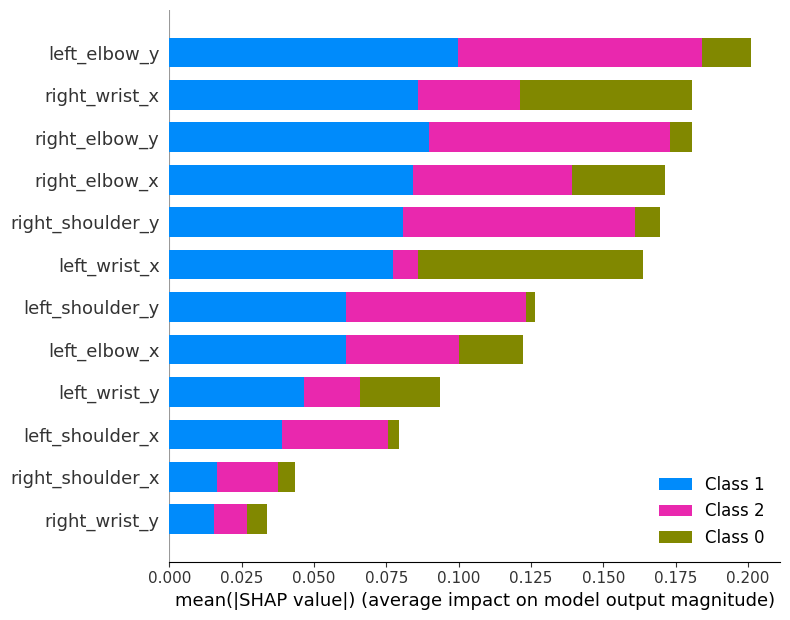

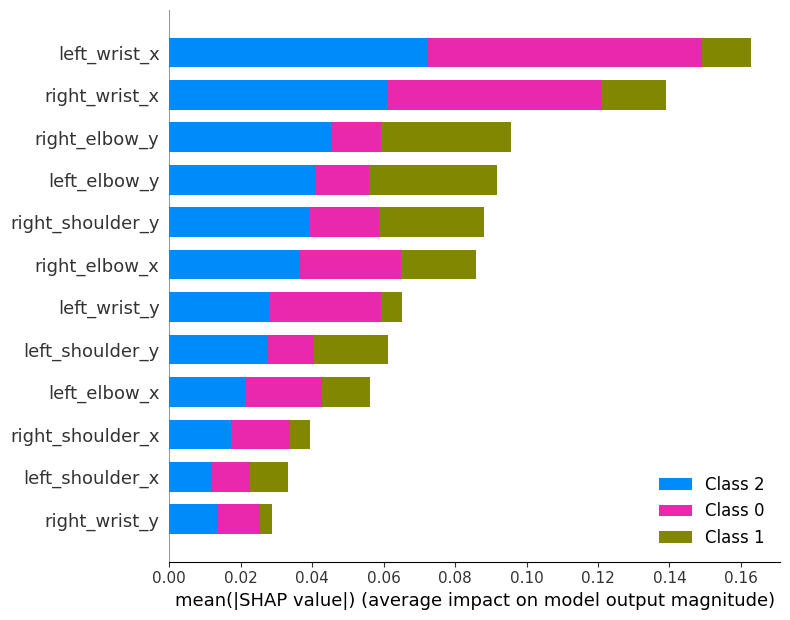

In [ ]:
# 클래스별 SHAP 분석
for class_name, class_features in class_data.items():
    class_features = np.array(class_features)
    class_X = X[y == class_mapping[class_name]]

    # wrist, elbow, shoulder에 해당하는 특징 인덱스 가져오기
    wrist_left_idx = feature_names.index('left_wrist_x')
    wrist_right_idx = feature_names.index('right_wrist_x')
    elbow_left_idx = feature_names.index('left_elbow_x')
    elbow_right_idx = feature_names.index('right_elbow_x')
    shoulder_left_idx = feature_names.index('left_shoulder_x')
    shoulder_right_idx = feature_names.index('right_shoulder_x')
    feature_indices = [
        wrist_left_idx, wrist_left_idx + 1, wrist_right_idx, wrist_right_idx + 1,
        elbow_left_idx, elbow_left_idx + 1, elbow_right_idx, elbow_right_idx + 1,
        shoulder_left_idx, shoulder_left_idx + 1, shoulder_right_idx, shoulder_right_idx + 1
    ]

    # 해당 특징만을 가지고 SHAP 값을 다시 계산
    class_X_selected = class_X[:, feature_indices]
    shap_values_class = explainer.shap_values(class_X_selected)

    # SHAP 그래프 생성
    shap.summary_plot(
        shap_values_class, class_X_selected,
        feature_names=[
            'left_wrist_x', 'left_wrist_y', 'right_wrist_x', 'right_wrist_y',
            'left_elbow_x', 'left_elbow_y', 'right_elbow_x', 'right_elbow_y',
            'left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x', 'right_shoulder_y'
        ]
    )

In [ ]:
# Force plot 생성 예시
# 예측 대상 데이터 선택 (임의로 첫 번째 데이터 선택)
sample_data = X[0]

# SHAP 값 계산
shap_values = explainer.shap_values(sample_data)

# Force plot 출력
shap.initjs()
shap.force_plot(
    explainer.expected_value[0],  # 기본 클래스의 예측 평균값
    shap_values[0],  # 선택한 데이터의 SHAP 값
    feature_names=[
        'left_wrist_x', 'left_wrist_y', 'right_wrist_x', 'right_wrist_y',
        'left_elbow_x', 'left_elbow_y', 'right_elbow_x', 'right_elbow_y',
        'left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x', 'right_shoulder_y'
    ]
)


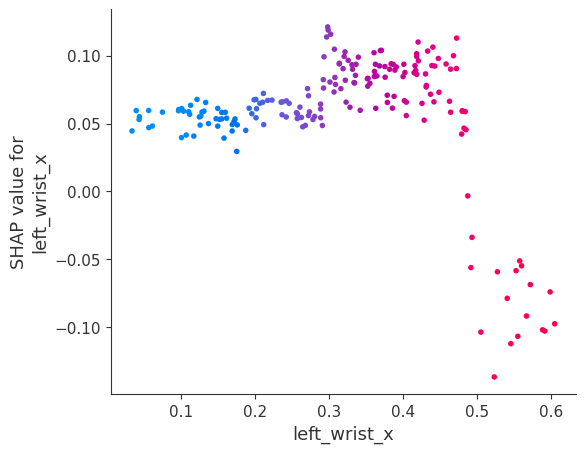

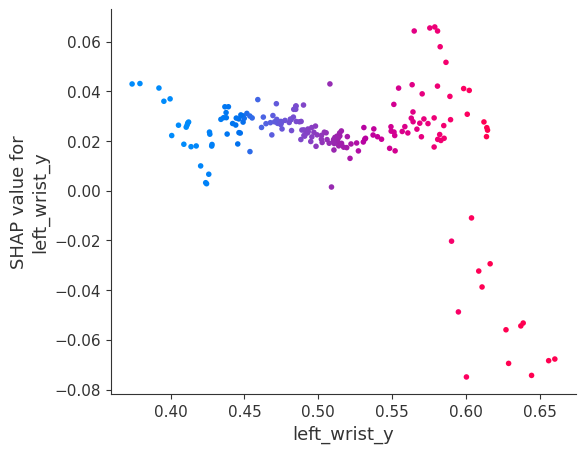

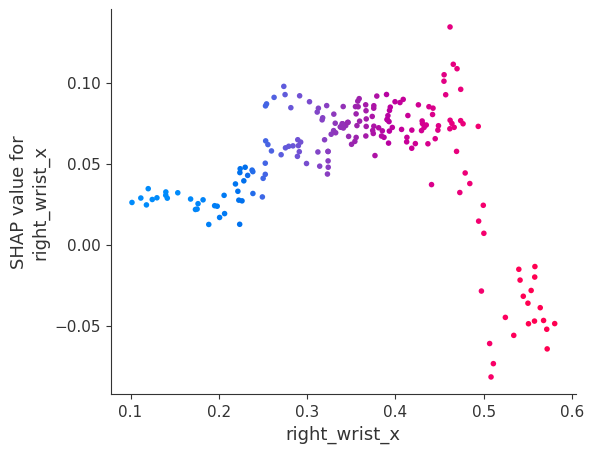

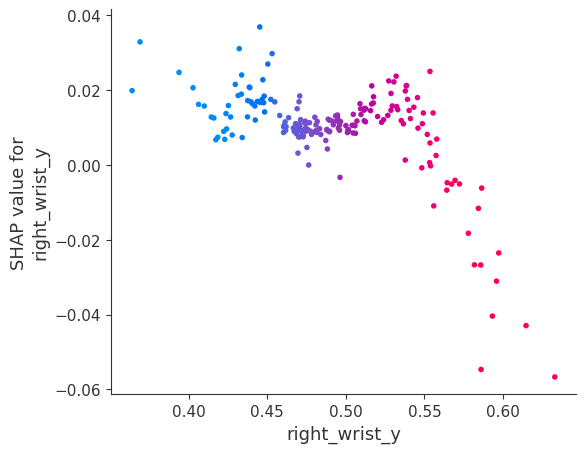

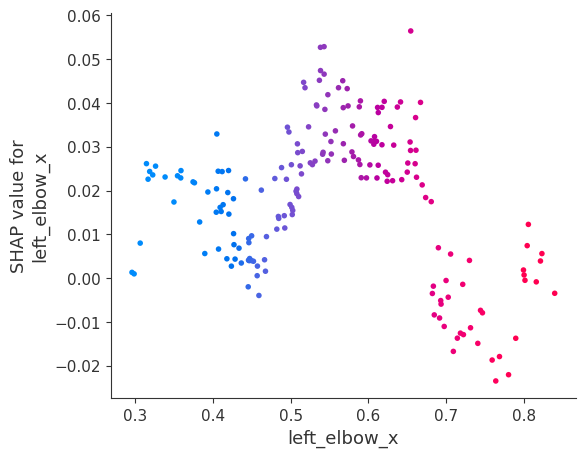

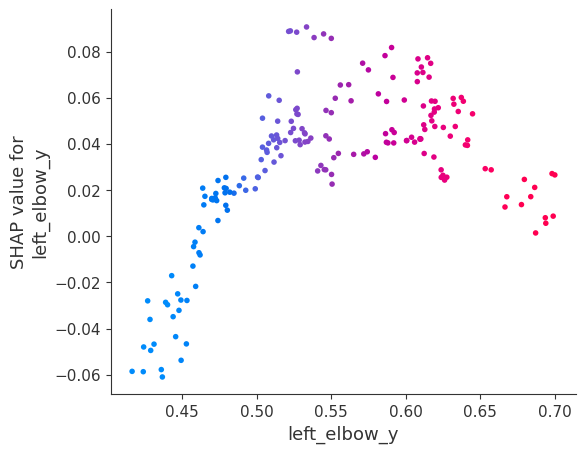

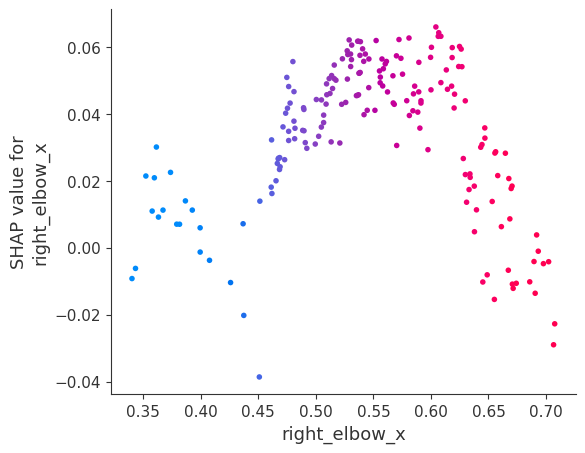

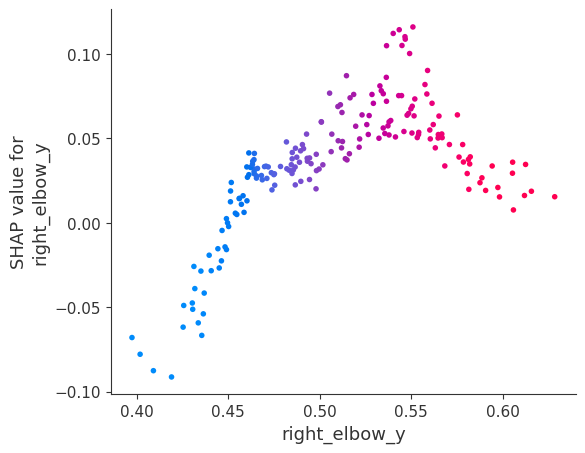

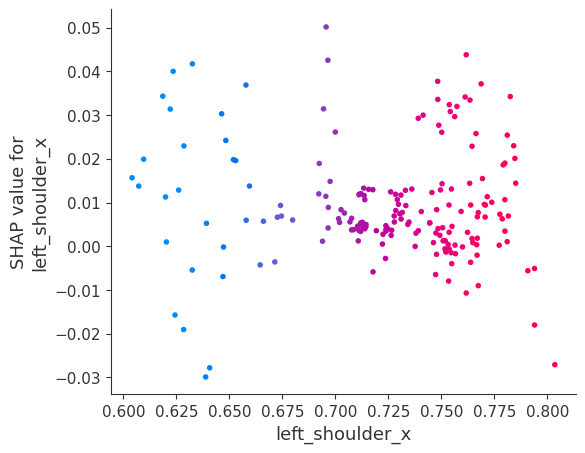

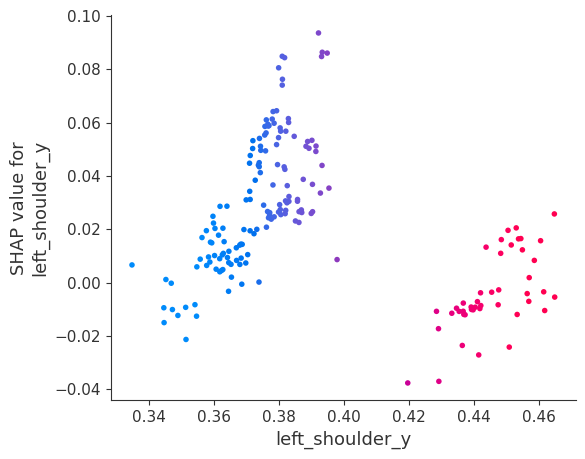

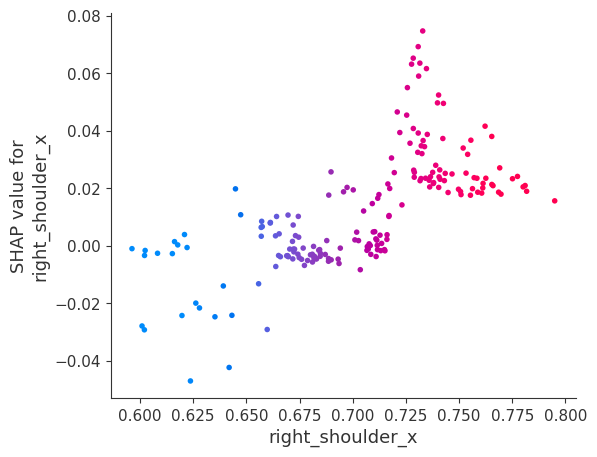

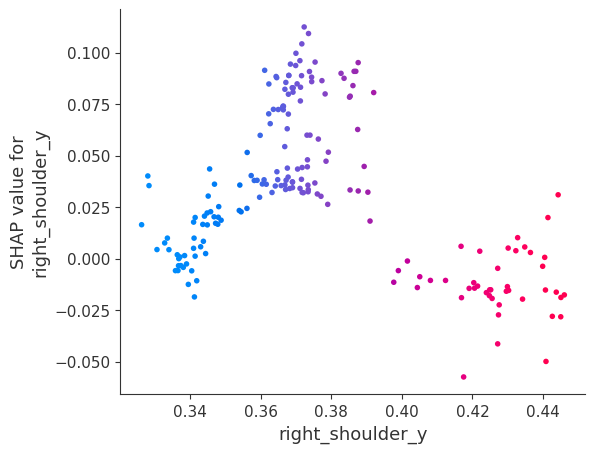

In [ ]:
# Generating dependency plots for all features
for feature_name in feature_names:
    shap.dependence_plot(
        feature_name,  # Current feature name
        shap_values_class[2],  # 해당 클래스에 대한 SHAP 값
        class_X_selected,  # 선택한 데이터
        feature_names=[
            'left_wrist_x', 'left_wrist_y', 'right_wrist_x', 'right_wrist_y',
            'left_elbow_x', 'left_elbow_y', 'right_elbow_x', 'right_elbow_y',
            'left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x', 'right_shoulder_y'
        ],
        interaction_index=feature_name  # 현재 특성에 대한 interaction_index 설정
    )